<a href="https://colab.research.google.com/github/oluwamayowaa/Cars-45-assignment/blob/main/car%20price%20prediction%20using%20pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libraries

In [1]:
import pyspark
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
%matplotlib inline
sns.set_theme(context= 'paper', style= 'whitegrid', palette= 'deep', font= 'monospace', font_scale= 1)
print(pyspark.__version__)

3.5.3


In [2]:
from pyspark.sql import SparkSession
spark= SparkSession.builder.appName('regression').getOrCreate()

In [3]:
def load_and_preprocess_data(file_path):
    df= spark.read.csv(file_path, inferSchema= True, header= True)
    return df

In [4]:
df= load_and_preprocess_data('/content/drive/MyDrive/ds assignment/Cars_Data_CSV.csv')
df.show()

+----+-----+-------+----------------+-------------------+------------+---------+----------+------------+----------+----------+---------+--------------------+---------+
|make|model|mileage|manufacture_year|engine_displacement|engine_power|body_type|color_slug|transmission|door_count|seat_count|fuel_type|        date_created|price_NGN|
+----+-----+-------+----------------+-------------------+------------+---------+----------+------------+----------+----------+---------+--------------------+---------+
|audi| NULL| 330000|            1995|               2600|         110|  compact|      NULL|        auto|      None|      None| gasoline|2015-11-14 20:10:...|   873428|
|audi|  200|   NULL|            1995|               NULL|        NULL|  compact|      NULL|        NULL|      None|      None| gasoline|2015-11-14 20:11:...|    66616|
|audi| NULL|   NULL|            1995|              11199|        NULL|  compact|      NULL|        NULL|      None|      None| gasoline|2015-11-14 20:11:...|   

In [5]:
# inspecting the column dtypes

df.printSchema()

root
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- mileage: integer (nullable = true)
 |-- manufacture_year: integer (nullable = true)
 |-- engine_displacement: integer (nullable = true)
 |-- engine_power: integer (nullable = true)
 |-- body_type: string (nullable = true)
 |-- color_slug: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- door_count: string (nullable = true)
 |-- seat_count: string (nullable = true)
 |-- fuel_type: string (nullable = true)
 |-- date_created: timestamp (nullable = true)
 |-- price_NGN: long (nullable = true)



In [6]:
numerical_columns= ['door_count', 'seat_count']

In [7]:
# converting numerical columns to the appropriate data type
for i in numerical_columns:
    df= df.withColumn(i, df[i].cast('int'))

In [8]:
df.printSchema()

root
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- mileage: integer (nullable = true)
 |-- manufacture_year: integer (nullable = true)
 |-- engine_displacement: integer (nullable = true)
 |-- engine_power: integer (nullable = true)
 |-- body_type: string (nullable = true)
 |-- color_slug: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- door_count: integer (nullable = true)
 |-- seat_count: integer (nullable = true)
 |-- fuel_type: string (nullable = true)
 |-- date_created: timestamp (nullable = true)
 |-- price_NGN: long (nullable = true)



In [9]:
df.describe().show()

+-------+------+------------------+------------------+-----------------+-------------------+------------------+---------+----------+------------+------------------+------------------+---------+--------------------+
|summary|  make|             model|           mileage| manufacture_year|engine_displacement|      engine_power|body_type|color_slug|transmission|        door_count|        seat_count|fuel_type|           price_NGN|
+-------+------+------------------+------------------+-----------------+-------------------+------------------+---------+----------+------------+------------------+------------------+---------+--------------------+
|  count|638562|            454990|            603981|           638562|             489134|            537375|    72636|         0|      541441|            451206|            409865|   638562|              638562|
|   mean|  NULL|306.40944189228816|115283.86027209465|2008.724717411935| 2100.2289311313466|105.05205117469178|     NULL|      NULL|        

## Handling Missing Values

In [10]:
# Calculate the percentage of null values for each column in the DataFrame

null_percentage_df = df.select([
    (count(when(col(c).isNull(), c)) / df.count() * 100).alias(c) for c in df.columns])

null_percentage_df.show()

+----+-----------------+----------------+----------------+-------------------+------------------+----------------+----------+------------------+------------------+-----------------+---------+------------+---------+
|make|            model|         mileage|manufacture_year|engine_displacement|      engine_power|       body_type|color_slug|      transmission|        door_count|       seat_count|fuel_type|date_created|price_NGN|
+----+-----------------+----------------+----------------+-------------------+------------------+----------------+----------+------------------+------------------+-----------------+---------+------------+---------+
| 0.0|28.74771752782032|5.41544908716773|             0.0|  23.40070345557675|15.846072895036034|88.6250669472972|     100.0|15.209329712698219|29.340298984280306|35.81437667759747|      0.0|         0.0|      0.0|
+----+-----------------+----------------+----------------+-------------------+------------------+----------------+----------+---------------

In [11]:
total_rows= df.count() # the total numbers of enteries in the dataset
missing_perct= df.select([((count(when(col(c).isNull(), c)) / total_rows * 100)).alias(c) for c in df.columns])
missing_df= missing_perct.toPandas().astype('int').T
missing_df.columns = ['%']
missing_df[:]

,%
make,0
model,28
mileage,5
manufacture_year,0
engine_displacement,23
engine_power,15
body_type,88
color_slug,100
transmission,15
door_count,29


Visualizing the plot of missing values per column:

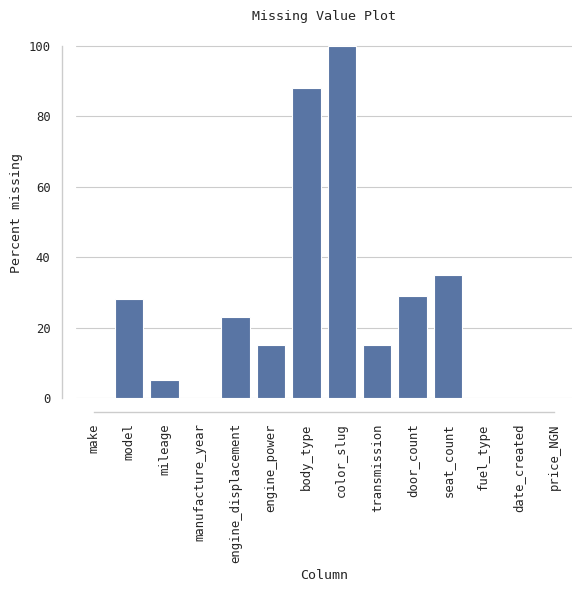

In [12]:
sns.barplot(data= missing_df, x= missing_df.index, y= '%')
sns.despine(offset=10, trim=True)
plt.xticks(rotation= 90)
plt.ylabel('Percent missing')
plt.xlabel('Column')
plt.title('Missing Value Plot')
plt.show()

The analysis of the dataset reveals that the `body_type` and `color_slug` columns have a significant proportion of missing values—88% and 100%, respectively. I will drop columns with 30% or more missing values. Additionally, the `date_created` column is not useful for modeling. Consequently, the `body_type`, `color_slug`, `seat_count`, and `date_created` columns will be removed from the dataframe.


In [13]:
def handle_missing_values(df, columns_to_drop):
    for column in columns_to_drop:
        df= df.drop(column)
    return df

In [14]:
columns_to_drop= ['body_type', 'color_slug', 'seat_count', 'date_created']
df= handle_missing_values(df, columns_to_drop)

### Handling missing values in categorical columns.

**Model**

In [15]:
missing_model_count= df.filter(col('model').isNull()).count()
print(f'There are {missing_model_count} null values in the model colum')

There are 183572 null values in the model colum



I will create a new column in the DataFrame to indicate whether the `model` column contains null values.


In [16]:
df= df.withColumn('known_model', when(df.model.isNotNull(), 1).otherwise(0))

**Transmission**

In [17]:
# finding the number of missing values in the transmission column

transmission_count= df.groupBy('transmission').agg(
    count('transmission').alias('frequency'),
    count(when(col('transmission').isNull(), 1)).alias('null_count'))

transmission_count.show()

+------------+---------+----------+
|transmission|frequency|null_count|
+------------+---------+----------+
|         man|   360588|         0|
|        auto|   180853|         0|
|        NULL|        0|     97121|
+------------+---------+----------+





I will add a new column to the DataFrame to indicate the presence of unknown transmission types.


In [18]:
df= df.withColumn(
    'new_transmission',
    when(df.transmission == 'man', 'manual')
    .when(df.transmission == 'auto', 'automatic')
    .otherwise('unknown')
)

**Fuel Type**

In [19]:
# Group by fuel_type

fuel_type_count= df.groupBy('fuel_type').agg(
    count('fuel_type').alias('frequency'),
    count(when(col('fuel_type').isNull(), 1)).alias('null_count')
)

fuel_type_count.show()

+---------+---------+----------+
|fuel_type|frequency|null_count|
+---------+---------+----------+
| gasoline|   340676|         0|
|   diesel|   297886|         0|
+---------+---------+----------+



I will utilize Spark's StringIndexer to transform the `new_transmission` and `fuel_type` columns into indexed values.

In [20]:
categorical_cols= ['new_transmission', 'fuel_type']

indexer= StringIndexer(
    inputCols= categorical_cols,
    outputCols= [c + '_index' for c in categorical_cols]
)

df= indexer.fit(df).transform(df)

In [21]:
df= df.drop('transmission')\
.drop('new_transmission')\
.drop('fuel_type')


In [22]:
# Inspecting the dataframe

df.show(5)

+----+-----+-------+----------------+-------------------+------------+----------+---------+-----------+----------------------+---------------+
|make|model|mileage|manufacture_year|engine_displacement|engine_power|door_count|price_NGN|known_model|new_transmission_index|fuel_type_index|
+----+-----+-------+----------------+-------------------+------------+----------+---------+-----------+----------------------+---------------+
|audi| NULL| 330000|            1995|               2600|         110|      NULL|   873428|          0|                   1.0|            0.0|
|audi|  200|   NULL|            1995|               NULL|        NULL|      NULL|    66616|          1|                   2.0|            0.0|
|audi| NULL|   NULL|            1995|              11199|        NULL|      NULL|    66616|          0|                   2.0|            0.0|
|audi| NULL|   NULL|            1995|               NULL|        NULL|      NULL|    66604|          0|                   2.0|            0.0|

### Handling missing values in numerical columns.

In [23]:
# Inspecting the unique car brands in the dataframe

df.select('make').distinct().count()

37

In [24]:
df2= df.select('make', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'known_model', 'new_transmission_index', 'fuel_type_index', (df.price_NGN).alias('price'))

df2.show()

+----+-------+----------------+-------------------+------------+----------+-----------+----------------------+---------------+------+
|make|mileage|manufacture_year|engine_displacement|engine_power|door_count|known_model|new_transmission_index|fuel_type_index| price|
+----+-------+----------------+-------------------+------------+----------+-----------+----------------------+---------------+------+
|audi| 330000|            1995|               2600|         110|      NULL|          0|                   1.0|            0.0|873428|
|audi|   NULL|            1995|               NULL|        NULL|      NULL|          1|                   2.0|            0.0| 66616|
|audi|   NULL|            1995|              11199|        NULL|      NULL|          0|                   2.0|            0.0| 66616|
|audi|   NULL|            1995|               NULL|        NULL|      NULL|          0|                   2.0|            0.0| 66604|
|audi| 347000|            1995|               NULL|          8

In [25]:
distinct_brands= df.select('make').distinct().toPandas()
brand_list= sorted(distinct_brands['make'].tolist())

In [26]:
feature_columns= ['mileage', 'engine_displacement', 'engine_power', 'door_count']

# Initiating the imputer
imputer= Imputer(inputCols= feature_columns, outputCols= [f'imputed_{c}' for c in feature_columns])

Splitting the dataframe into a list of dataframes with each dataframe containing only enteries with distinct makes.

In [27]:
data= []

for i in brand_list:
    sub_df= df2.filter(col('make')== i)
    transformed_df= imputer.setStrategy('median').fit(sub_df).transform(sub_df)
    data.append(transformed_df)

## Handling Outliers in the dataset.

In [28]:
# Inspecting the columns with numerical values

df2.select('mileage', 'engine_displacement', 'engine_power', 'door_count', 'price').summary().show()

+-------+------------------+-------------------+------------------+------------------+--------------------+
|summary|           mileage|engine_displacement|      engine_power|        door_count|               price|
+-------+------------------+-------------------+------------------+------------------+--------------------+
|  count|            603981|             489134|            537375|            451206|              638562|
|   mean|115283.86027209465| 2100.2289311313466|105.05205117469178| 3.679583161571433|   6171796.440903154|
| stddev| 365012.4206961075| 1931.0723759889524| 53.30300585077408|0.8441266801049992|1.7985859242684588E8|
|    min|                 0|                 10|                 3|                 1|                  16|
|    25%|             22000|               1461|                73|                 4|             1600592|
|    50%|             82500|               1898|                94|                 4|             3980296|
|    75%|            150000|

Key observations based on the information obtained:


1.   The dataset exhibits a significant disparity between the minimum and maximum car prices.
2.   The `mileage` column also displays a substantial range between its third quantile and maximum values, indicating the presence of potential outliers. Same with `engine_displacement`.
3.   A maximum value of 999 HP for `engine_power` is also very high. While some cars might pack such power, one could assume that this is a data entry error.


To handle outliers in the dataset, I will apply winsorization. This technique involves capping the extreme values in the data to reduce the effect of possibly outliers. By limiting the range of the data, winsorization helps to ensure that the analysis is not influenced by extreme values, leading to more reliable results.

In [29]:
def calculate_quantile(data, column_name, lower_limit, upper_limit):
    quantiles= data.approxQuantile([column_name], [lower_limit, upper_limit], 0.05)
    return quantiles[0]

def filter_value(data, column_name, min_value, max_value):
    data= data.withColumn(column_name,
        when(data[column_name] < min_value, min_value)
        .when(data[column_name] > max_value, max_value)
        .otherwise(data[column_name]))
    return data

In [30]:
train_df= []

for i in data:
    price_caps= calculate_quantile(data= i, column_name= 'price', lower_limit=0.1, upper_limit=0.9)
    mileage_caps= calculate_quantile(data= i, column_name= 'imputed_mileage', lower_limit=0.2, upper_limit=0.8)

    df= filter_value(data= i, column_name= 'price', min_value= price_caps[0], max_value= price_caps[1])
    df= filter_value(data= df, column_name= 'imputed_mileage', min_value= mileage_caps[0], max_value= mileage_caps[1])
    df= filter_value(data= df, column_name= 'imputed_engine_displacement', min_value= 1000, max_value= 5000)
    df= filter_value(data= df, column_name= 'imputed_engine_power', min_value= 50, max_value= 650)

    train_df.append(df)


## Merging the dataframes

In [31]:
merged_df= train_df[0]
for i in train_df[1:]:
    merged_df= merged_df.union(i)

In [32]:
merged_df.show(5)

+----+-------+----------------+-------------------+------------+----------+-----------+----------------------+---------------+--------+---------------+---------------------------+--------------------+------------------+
|make|mileage|manufacture_year|engine_displacement|engine_power|door_count|known_model|new_transmission_index|fuel_type_index|   price|imputed_mileage|imputed_engine_displacement|imputed_engine_power|imputed_door_count|
+----+-------+----------------+-------------------+------------+----------+-----------+----------------------+---------------+--------+---------------+---------------------------+--------------------+------------------+
|audi| 330000|            1995|               2600|         110|      NULL|          0|                   1.0|            0.0|873428.0|       173500.0|                       2600|                 110|                 4|
|audi|   NULL|            1995|               NULL|        NULL|      NULL|          1|                   2.0|          

In [33]:
# converting the column types for uniformity

merged_df= merged_df.withColumn('new_transmission_index', merged_df['new_transmission_index'].cast('int'))
merged_df= merged_df.withColumn('fuel_type_index', merged_df['fuel_type_index'].cast('int'))
merged_df= merged_df.withColumn('price', merged_df['price'].cast('long'))
merged_df= merged_df.withColumn('imputed_mileage', merged_df['imputed_mileage'].cast('int'))

In [34]:
merged_df= handle_missing_values(merged_df, ['mileage', 'engine_displacement', 'engine_power', 'door_count'])

In [35]:
# duplicating the price colum to a pandas list object

price_pdf= merged_df.select('price').toPandas().astype('int64')
quote_pdf= df2.select('price').toPandas().astype('int64')

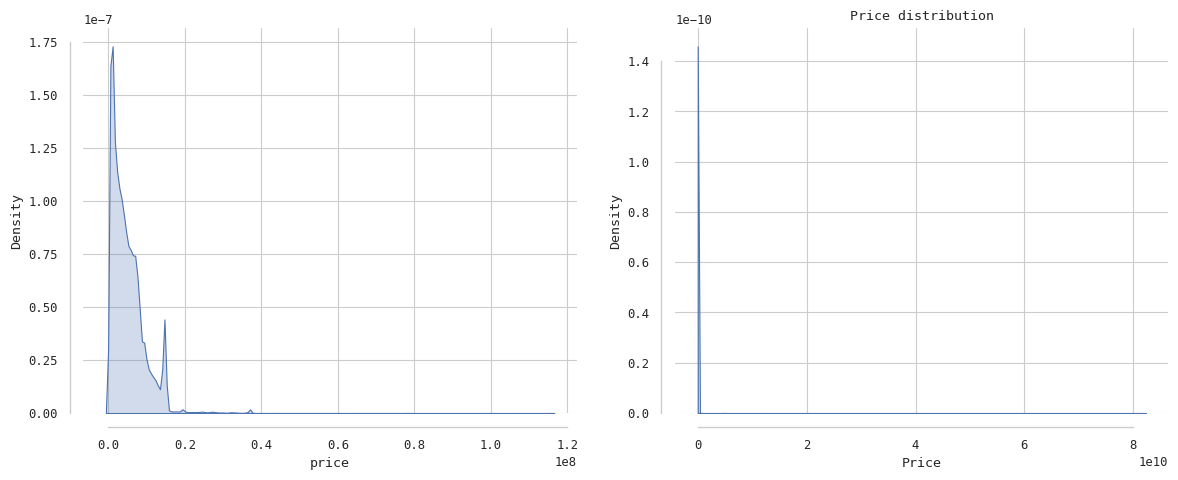

In [36]:
# Visualizing the distribution of the prices before (R) and after (L) winsorization

fig, (ax1, ax2)= plt.subplots(ncols= 2, figsize= (14, 5))

sns.kdeplot(x= price_pdf['price'], fill= True, ax= ax1)

sns.kdeplot(x= quote_pdf['price'], fill= True, ax= ax2)

sns.despine(offset=10, trim=True)
plt.title('Price distribution')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

Based on the plot, we can infer the following:

1.   Skewness: The distribution is heavily skewed to the right, meaning there are a few very high-priced items that significantly pull the mean to the right.
2.   Multimodality: There are be multiple peaks (modes) in the distribution, showing that there are distinct groups of items with different price ranges. This is due to different car makes.



I would apply a log transformation on the dataframe so that the right-skewed distribution would become less skewed, in a bid to make it more symmetrical.

In [37]:
merged_df= merged_df.withColumn('log_price', log(merged_df['price']))

In [38]:
# duplicating the log_price colum to a pandas list object

log_price_pdf= merged_df.select('log_price').toPandas()

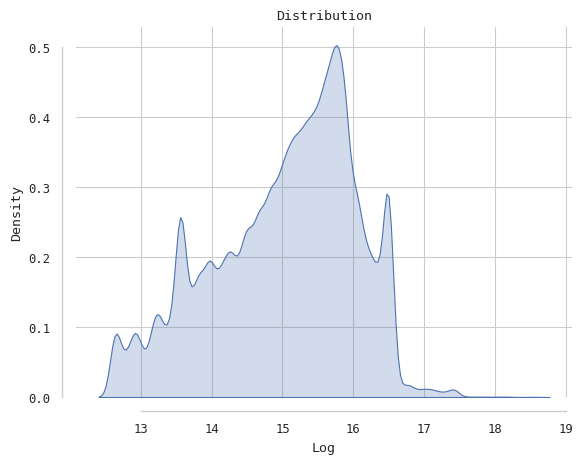

In [39]:
# Visualizing the effect of the log transformation on the distribution

sns.kdeplot(x= log_price_pdf['log_price'], fill= True)
sns.despine(offset=10, trim=True)
plt.title('Distribution')
plt.xlabel('Log')
plt.ylabel('Density')
plt.show()

In [40]:
# Dropping duplicate rows in the dataframe

merged_df= merged_df.distinct()

## Feature Engineering

I will add two columns to the dataframe:

1.   `miles_per_year`: to provide context to how much the car has been used.
2.   `engine_effciency`: to indicate how efficient the engine is in converting fuel to power.



In [41]:
def engineer_features (data):
    data= data.withColumn('miles_per_year', F.col('imputed_mileage') / (2024 - F.col('manufacture_year')))
    data= data.withColumn('engine_efficiency', F.col('imputed_engine_power') / F.col('imputed_engine_displacement'))
    return data

In [42]:
merged_df= engineer_features(merged_df)

In [43]:
merged_df.show(5)

+----+----------------+-----------+----------------------+---------------+--------+---------------+---------------------------+--------------------+------------------+------------------+------------------+-------------------+
|make|manufacture_year|known_model|new_transmission_index|fuel_type_index|   price|imputed_mileage|imputed_engine_displacement|imputed_engine_power|imputed_door_count|         log_price|    miles_per_year|  engine_efficiency|
+----+----------------+-----------+----------------------+---------------+--------+---------------+---------------------------+--------------------+------------------+------------------+------------------+-------------------+
|audi|            1995|          1|                     2|              0|  759912|          85000|                       1800|                 120|                 4| 13.54095791608471|2931.0344827586205|0.06666666666666667|
|audi|            1995|          1|                     2|              0| 2201228|         1735

In [44]:
# Creating a list of relevant features that will be fed into the assembler

feature_list= [
    'manufacture_year',
    'known_model',
    'new_transmission_index',
    'fuel_type_index',
    'imputed_mileage',
    'imputed_engine_displacement',
    'imputed_engine_power',
    'imputed_door_count',
    'miles_per_year',
    'engine_efficiency'
]

# Instantiating the assembler

assembler= VectorAssembler(
    inputCols= feature_list,
    outputCol= 'features'
)


feature_vector= assembler.transform(merged_df)

## Train/Test split

In [45]:
# Splitting the data into both train and test/validation sets

train, test= feature_vector.randomSplit([0.7, 0.3], seed= 42)

## Scaling the data

In [46]:
# Creating a scaler object

scaler= StandardScaler(
    inputCol= 'features',
    outputCol= 'features_scaled'
)

# fitting the scaler on the training data

scaler_model= scaler.fit(train)

# applying the transformation on the training data

scaled_train= scaler_model.transform(train)

## Modeling

I will use the XGBoost algorithm to make predictions on the data.

In [47]:
! pip install xgboost
from xgboost.spark import SparkXGBRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import RegressionMetrics

In [48]:
# Defining the model

xgb_regressor= SparkXGBRegressor(features_col= 'features_scaled',
                                 label_col= 'log_price',
                                 num_workers= 2,
                                 device= 'cpu')

In [51]:
# Builidng the hyperparameter grid

grid= (ParamGridBuilder()
.addGrid(xgb_regressor.learning_rate, [0.05, 0.1])
.addGrid(xgb_regressor.n_estimators, [1000, 1250])
.addGrid(xgb_regressor.max_depth, [7])
.build()
)

In [52]:
# Creating an evaluator

evaluator= RegressionEvaluator(labelCol= 'log_price', predictionCol= 'prediction', metricName= 'rmse')

In [53]:
# Cross validation

cv= CrossValidator(estimator= xgb_regressor,
                   estimatorParamMaps= grid,
                   evaluator= evaluator,
                   numFolds= 5)

In [54]:
# Fitting the model

cv_model= cv.fit(scaled_train)

INFO:XGBoost-PySpark:Running xgboost-2.1.2 on 2 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 7, 'objective': 'reg:squarederror', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 1000}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.1.2 on 2 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 7, 'objective': 'reg:squarederror', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 1250}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.1.2 on 2 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'reg:squarederror', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 1000}
	dmatrix_kwargs: {'nthread': 1, 'missi

In [55]:
# Assuming cvModel is your fitted CrossValidator model
best_model = cv_model.bestModel

# Access the best hyperparameters using extractParamMap
best_hyperparameters = best_model.extractParamMap()

print("Best Hyperparameters:")
for param, value in best_hyperparameters.items():
    print(f"{param.name}: {value}")

Best Hyperparameters:
enable_sparse_data_optim: False
featuresCol: features_scaled
features_cols: []
labelCol: log_price
predictionCol: prediction
arbitrary_params_dict: {}
base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: None
device: cpu
early_stopping_rounds: None
eval_metric: None
feature_names: None
feature_types: None
feature_weights: None
force_repartition: False
gamma: None
grow_policy: None
importance_type: None
interaction_constraints: None
iteration_range: None
learning_rate: 0.1
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: 7
max_leaves: None
min_child_weight: None
missing: nan
monotone_constraints: None
multi_strategy: None
n_estimators: 1250
num_parallel_tree: None
num_workers: 2
objective: reg:squarederror
random_state: None
reg_alpha: None
reg_lambda: None
repartition_random_shuffle: False
sampling_method: None
scale_pos_weight: None
subsample: None
tree_method:

In [56]:
# applying the scalaer transform to the test data

scaled_test= scaler_model.transform(test)

## Predictions

In [57]:
# test predictions
test_predictions= best_model.transform(scaled_test)
test_rmse= evaluator.evaluate(test_predictions)

print(f'The RMSE is {test_rmse}')

The RMSE is 0.2647241898264987


In [58]:
target_and_preds= test_predictions.select('log_price', 'prediction').rdd
metrics= RegressionMetrics(target_and_preds)
r2_score= metrics.r2
print(f'The R-squared score is: {r2_score}')

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


The R-squared score is: 0.916211818715235


In [59]:
test_predictions= test_predictions.withColumn('predicted_price', exp(test_predictions['prediction']))
test_predictions= test_predictions.withColumn('predicted_price', test_predictions['predicted_price'].cast('long'))

In [60]:
test_predictions= test_predictions.withColumn('error', test_predictions['price'] - test_predictions['predicted_price'])

In [61]:
preds_df= test_predictions.select('price', 'predicted_price', 'error')
preds_df.show()

+-------+---------------+-------+
|  price|predicted_price|  error|
+-------+---------------+-------+
| 759912|         792834| -32922|
| 759912|         823569| -63657|
|1200444|        1670607|-470163|
|2100236|        1353653| 746583|
| 759912|         537034| 222878|
| 759912|         738985|  20927|
| 759912|         822887| -62975|
| 759912|         756634|   3278|
| 759912|         848215| -88303|
| 759912|        1263904|-503992|
| 759912|         556301| 203611|
| 759912|         838192| -78280|
| 759912|         838701| -78789|
| 759912|         711946|  47966|
| 759912|         906618|-146706|
| 759912|        1236982|-477070|
| 759912|         975682|-215770|
| 759912|         864119|-104207|
| 796120|         864119| -67999|
| 799688|         642892| 156796|
+-------+---------------+-------+
only showing top 20 rows

